In [1]:
import os
from glob import glob
import nbimporter
import pandas as pd
import numpy as np

from ResNet34 import ResnetBuilder
from DataParserForCNN import read_class, read_full_df, null_augment, drawing_to_image
from keras import backend as K
from DataParserForCNN import ImageBatchGenerator
from keras.utils import Sequence

import matplotlib.pyplot as plt
%matplotlib inline

Importing Jupyter notebook from ResNet34.ipynb


Using TensorFlow backend.


Importing Jupyter notebook from DataParserForCNN.ipynb


In [2]:
def get_model(net, weight_path):
    
    if net == 'wavenet':
        wavenet_params = WaveNetParams()
        model = WaveNet(wavenet_params)
        
    elif net == 'resnet34':
        K.set_image_dim_ordering('tf')
        model = ResnetBuilder.build_resnet_34((3, 64, 64), 340)
    
    elif net == 'resnet50':
        K.set_image_dim_ordering('tf')
        model = ResnetBuilder.build_resnet_50((3, 64, 64), 340)
        
    model.load_weights(weight_path)
    
    return model

In [37]:
def evaluateTestSet(net, weight_path):
    result = model.evaluate(x_test, y_test, batch_size=2048)
    print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*result[1], 100*result[2]))

In [38]:
def sklearnReport(model, weight_path):
    model = model.load_weights(weight_path)
    test_cat = np.argmax(y_test, 1)
    pred_y = model.predict(x_test, batch_size = 4096)
    pred_cat = np.argmax(pred_y, 1)
    plt.matshow(confusion_matrix(test_cat, pred_cat))
    print(classification_report(test_cat, pred_cat, 
                            target_names = [x for x in word_encoder.classes_]))

In [9]:
model = get_model('resnet50', './model/qd_rn50_noisy26500.h5')

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [3]:
# base_path = '/home/jianing_sun/qd/data_split/'
base_path = '/Volumes/JS/QuickDraw/'
class_array = read_class()

In [4]:
full_df, train_id, valid_id = read_full_df(base_path, class_array)

	 load df   :  339/340                   zigzag   7 min 23 sec

	 load valid_set split:  339/340                   zigzag  11 min 20 sec

In [5]:
def normalize(image):
    return image / 255.

In [6]:
valid_batch = ImageBatchGenerator(
                                  class_array=class_array,
                                  full_df=full_df,
                                  datasplit_id=valid_id,
                                  split='valid_set',
                                  batch_size=128, 
                                  augment=null_augment, 
                                  mode='simplified', 
                                  norm=normalize,
                                  shuffle=True)

In [7]:
len(valid_batch[0])

2

In [11]:
from keras.optimizers import Adam
from keras.metrics import top_k_categorical_accuracy


def top_3_accuracy(y_true, y_pred): 
    return top_k_categorical_accuracy(y_true, y_pred, 3)


def ap_3(y_true, y_pred):
    score = 0.0
    num_tp = 0.0
    
    if len(y_pred) > 3:
        y_pred = y_pred[:3]

    for i, p in enumerate(y_pred):
        if p in y_true and p not in y_pred[:i]:
            num_tp += 1.0
            score += num_tp / (i+1.0)

    if not y_truth:
        return 0.0
    
    return score / min(len(y_true), 3)

def map3(y_true, y_pred):
    return (top_k_categorical_accuracy(y_true, y_pred, 3) + top_k_categorical_accuracy(y_true, y_pred, 2)
            + top_k_categorical_accuracy(y_true, y_pred, 1)) / 3

def map_3(y_true, y_pred):
    """ map average precision with maximum 3 predicted elements """
    return np.mean([ap_3(a, p) for a, p in zip(y_true, y_pred)])


optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', 
              metrics = ['accuracy', top_3_accuracy, map3],
              optimizer=optimizer)

In [12]:
result = model.evaluate_generator(valid_batch, verbose=1)

213/213 [==============================] - 517s 2s/step


In [14]:
print('Accuracy: %2.1f%%, Top 3: %2.1f%%, MAP@3: %2.1f%%' % (100*result[1], 100*result[2], 100*result[3]))

Accuracy: 79.5%, Top 3: 92.2%, MAP@3: 87.0%


In [8]:
def read_test_df(): 
    test_df = pd.read_csv('./test_%s.csv'%('simplified'))
#     test_id = np.arange(0, len(test_df))
    test_id = test_df['key_id'].values.astype(np.int64)

    return test_df, test_id

In [9]:
test_df, test_id = read_test_df()

In [56]:
test_df['key_id'].values

array([9000003627287624, 9000010688666847, 9000023642890129, ...,
       9999968529902445, 9999969540362833, 9999996442242305])

In [61]:
test_id[0]

9000003627287624

In [13]:
class TestGenerator(Sequence):
    def __init__(self, 
                 test_df,
                 datasplit_id,
                 split='test_set',
                 augment=null_augment, 
                 batch_size=128,
                 mode='simplified',
                 norm=None,
                 shuffle=True):
        """ data: could be 'train' or 'test', the former used to get splited dataset train_set or valid_set, 
                  the latter used to get the TEST_DF
        """
        assert mode in ['simplified', 'raw']
        
        self.datasplit_id = datasplit_id
        self.split = split
        self.norm = norm
        self.df = test_df
        
        self.augment = augment
        self.batch_size = batch_size
        self.mode = mode 
        self.H, self.W = 64, 64

        num_class = 340

        print('')

        ### shuffle                    
        if shuffle:
            np.random.shuffle(self.datasplit_id)
        print('\n')

        
    def __str__(self):
        N = len(self.datasplit_id)
        string = ''\
        + '\tdata         = %s\n'%self.split \
        + '\tmode         = %s\n'%self.mode \
        + '\tlen(self.datasplit_id) = %d\n'%N \
        + '\n'
        return string


    def __getitem__(self, idx):
        if self.split != 'test_set':
            l_bound = idx * self.batch_size
            r_bound = (idx + 1) * self.batch_size
            if r_bound > len(self.datasplit_id):
                r_bound = len(self.datasplit_id)
                l_bound = r_bound - self.batch_size
            instance_count = 0

            x_batch = np.zeros((r_bound-l_bound, self.H, self.W, 3))
            y_batch = np.zeros((r_bound-l_bound, 340), dtype='uint32')

            for instance in self.datasplit_id[l_bound:r_bound]:
                label, drawing_id, key_id = instance
                drawing = self.full_df[label]['drawing'][drawing_id]
                drawing = eval(drawing)

                image, label = self.augment(drawing, label, idx)

                x_batch[instance_count] = image
                y_batch[instance_count, int(label)] = 1

                if self.norm != None:
                    x_batch[instance_count] = self.norm(image)

                instance_count += 1
                
            return [x_batch, y_batch]
            
        else:
            l_bound = idx * self.batch_size
            r_bound = (idx + 1) * self.batch_size
            
            if r_bound > len(self.datasplit_id):
                r_bound = len(self.datasplit_id)
                l_bound = r_bound - self.batch_size
            instance_count = 0

            x_batch = np.zeros((r_bound - l_bound, self.H, self.W, 3))
            
            for instance in self.datasplit_id[l_bound:r_bound]:
                drawing_id = instance
                drawing = self.df['drawing'][idx]
                drawing = eval(drawing)
                
                label = None
                image, label = self.augment(drawing, label, idx)
                
                x_batch[instance_count] = image
                
                if self.norm != None:
                    x_batch[instance_count] = self.norm(image)

                instance_count += 1

            return x_batch


    def __len__(self):
        return int(np.ceil(len(self.datasplit_id) / self.batch_size))

In [7]:
class TestImageGenerator(Sequence):
    
    def __init__(self,
                test_df,
                test_id, 
                augment=null_augment):
        
        self.df = test_df
        self.id = test_id
        self.augment = augment
        
    def __getitem__(self, idx):
        
        label = None
        drawing = self.df['drawing'][idx]
        drawing = eval(drawing)
        
        print((self.augment(drawing, label, idx)[0]).ndim)
        return self.augment(drawing, label, idx)[0]
    
    def __len__(self):
        return int(len(self.id))

In [16]:
test_x = TestImageGenerator(test_df, test_id)

In [14]:
test_batch = TestGenerator(test_df, test_id, batch_size=1, norm=normalize, shuffle=False)

In [15]:
len(test_batch[0])

1

In [48]:
len(test_x)

10

In [52]:
type(test_x[0])

3


numpy.ndarray

In [54]:
type(test_x)

__main__.TestImageGenerator

In [37]:
len(test_id)

112199

In [65]:
np.array(test_batch[0][0]).shape

(64, 64, 3)

ValueError: could not broadcast input array from shape (2) into shape (64,64,3)

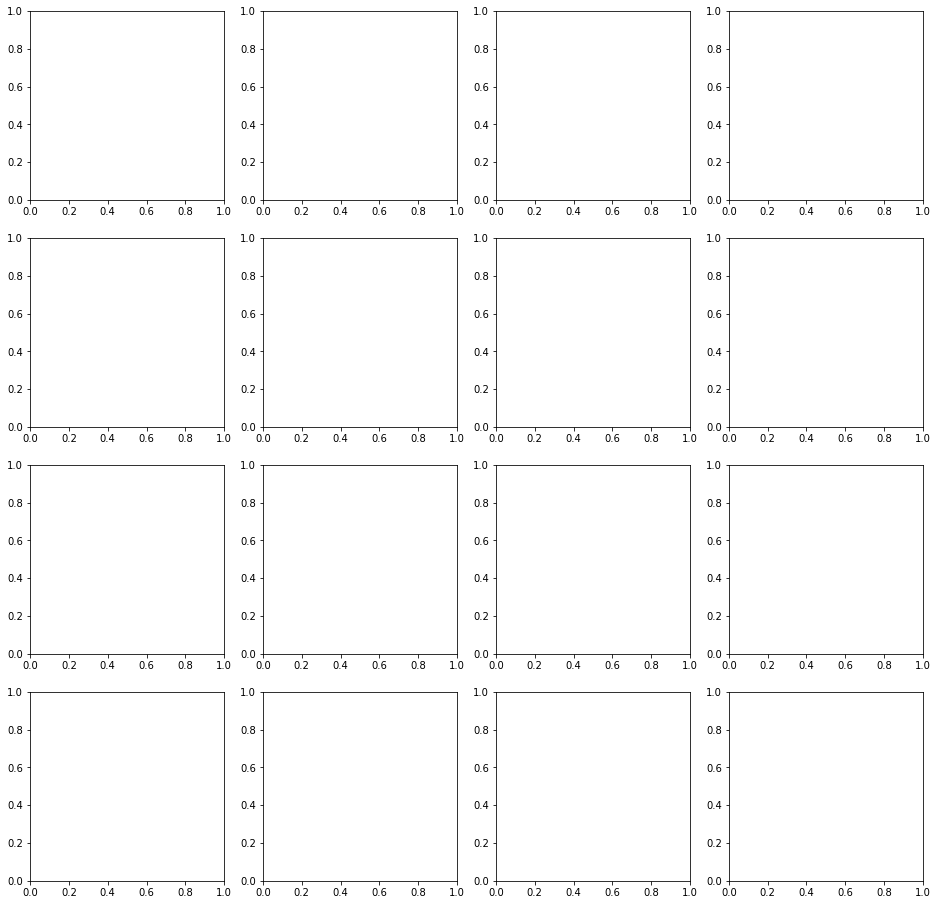

In [12]:
fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))

for i, ax in enumerate(m_axs.flatten()):
    img = test_batch[i][0]
    ax.imshow(img.astype('float'))

In [18]:
test_x = []
for i in range(10):
    drawing = test_df['drawing'][i]
    drawing = eval(drawing)
    
    img = drawing_to_image(drawing, 64, 64)
    img = img / 255.
    test_x.append(img)

In [19]:
test_x = np.array(test_x)

In [20]:
result = model.predict(test_x, verbose=True)

10/10 [==============================] - 1s 70ms/step


In [92]:
test_df['drawing'][:10]

0    [[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25...
1    [[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16...
2    [[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ...
3    [[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20...
4    [[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,...
5    [[[75, 71, 67, 65, 72, 83], [1, 0, 13, 67, 101...
6    [[[11, 130, 132, 124, 109, 81, 76, 76, 94, 117...
7    [[[168, 98, 58, 41, 26, 1, 0, 4, 11, 42, 47, 4...
8    [[[115, 106, 95, 88, 86, 91, 102, 115, 145, 16...
9    [[[20, 48, 160, 164, 167, 161, 145, 103, 93, 9...
Name: drawing, dtype: object

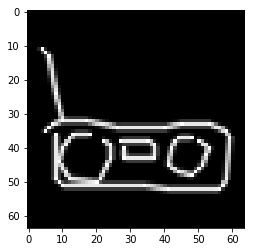

In [108]:
plt.imshow(test_x[0].astype('float'))

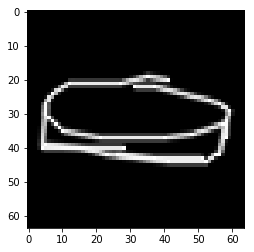

In [97]:
plt.imshow(test_x[1].astype('uint8'))

In [109]:
result = model.predict(test_x, verbose=True)

10/10 [==============================] - 0s 3ms/step


In [21]:
for r in result:
    print(np.argsort(-1*r)[:3])
    

[237 284  32]
[147  39 229]
[  1  65 113]
[190 306 319]
[116  59 168]
[113 160 286]
[335 154 334]
[292 176 331]
[ 41 104 139]
[154 326 335]


In [16]:
class_array = np.array(class_array)

In [115]:
class_array[[237,284, 269]]

array(['radio', 'stereo', 'snorkel'], dtype='<U23')

In [117]:
top_3_predicition = [class_array[np.argsort(-1*c_pred)[:3]] for c_pred in result]

In [125]:
top_3_predicition = np.squeeze(top_3_predicition)
top_3_predicition = [' '.join([col.replace(' ', '_') for col in row]) for row in top_3_predicition]

In [126]:
top_3_predicition

['radio stereo snorkel',
 'hockey_puck bottlecap pool',
 'The_Great_Wall_of_China castle camel',
 'mountain tent The_Eiffel_Tower',
 'campfire fireplace crown',
 'fence jail spreadsheet',
 'wine_glass hourglass floor_lamp',
 'submarine dolphin whale',
 'bracelet hand arm',
 'hourglass wine_glass vase']

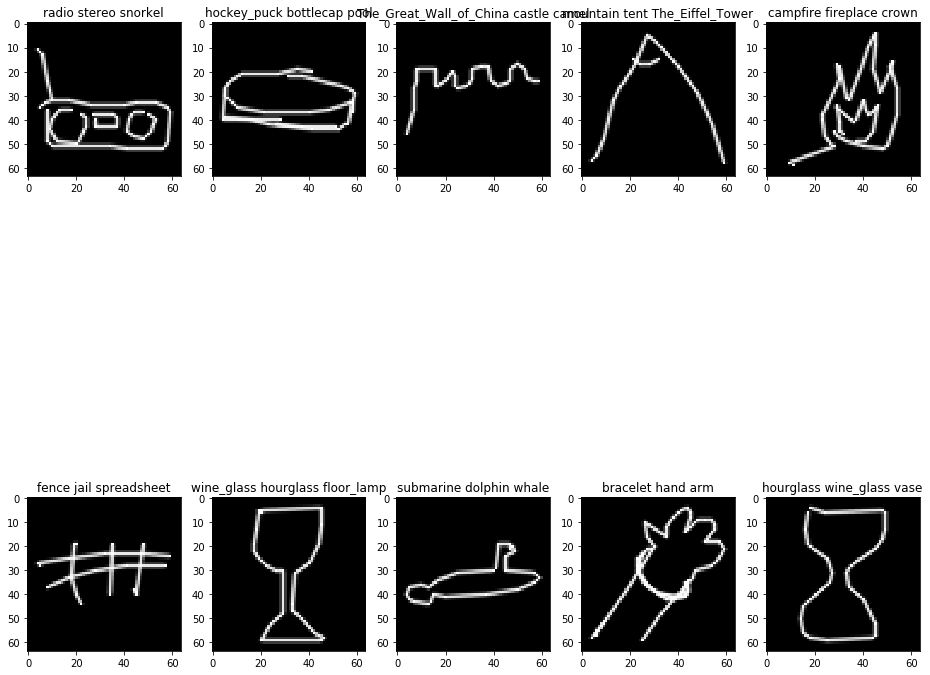

In [135]:
fig, m_axs = plt.subplots(2, 5, figsize=(16, 16))
for i, ax in enumerate(m_axs.flatten()):
    img = test_x[i]
    ax.imshow(img.astype('float'))
    ax.set_title(top_3_predicition[i])

In [170]:
test_id

array([9000003627287624, 9000010688666847, 9000023642890129, ...,
       9999968529902445, 9999969540362833, 9999996442242305])

In [17]:
test_y_preds = model.predict_generator(test_batch, verbose=True)

112199/112199 [==============================] - 4806s 43ms/step


In [18]:
top_3_predicition = [class_array[np.argsort(-1*pred)[:3]] for pred in test_y_preds]

In [19]:
top_3_predicition = np.squeeze(top_3_predicition)
top_3_predicition = [' '.join([col.replace(' ', '_') for col in row]) for row in top_3_predicition]

In [20]:
test_df['word'] = top_3_predicition

In [21]:
test_df[['key_id', 'word']].to_csv('rn50_noisy6500_Ocb28.csv', index=False)

In [42]:
print(test_y_preds[0])

[9.50271257e-08 4.85938074e-07 1.83150706e-09 1.17978288e-05
 5.70458687e-05 5.82155565e-07 1.62719438e-08 5.94897678e-08
 3.60444865e-05 8.87007161e-08 1.79244886e-08 1.64221979e-06
 1.79325184e-07 1.25231470e-08 4.07985752e-08 7.54107798e-09
 6.56326893e-06 4.60648153e-07 3.14017301e-09 9.04800359e-08
 6.18083618e-07 2.06328110e-08 2.00099866e-08 4.14372067e-07
 7.76965052e-08 4.23388471e-08 1.41970901e-07 4.03632912e-05
 3.56633763e-07 7.26215803e-05 6.66621176e-08 1.31199101e-07
 7.28604937e-05 7.90673571e-09 8.74714914e-08 4.93189646e-07
 5.45457397e-07 1.34900635e-09 8.68460859e-08 4.88589400e-08
 1.16906040e-06 2.86157160e-07 1.21159234e-08 5.12728036e-07
 5.83131019e-08 1.11278853e-09 8.24600406e-08 3.88921784e-09
 5.03396615e-04 1.41798382e-05 9.69061702e-08 2.25990192e-07
 3.76623888e-09 6.74830360e-08 7.43896607e-08 3.37156592e-07
 4.09381045e-08 1.23935206e-05 9.24600590e-06 7.79892595e-09
 8.39421599e-09 8.87538681e-06 3.50370965e-06 6.44228703e-06
 1.55521318e-09 2.827289